<a href="https://colab.research.google.com/github/ewapajak/ML/blob/main/homework09_multi_layer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  


##**MLP model from our class**:

In [2]:
import torch
import torchvision
from matplotlib import pyplot

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 605kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.37MB/s]


In [4]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

In [5]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(1*28*28, 1024)  #which is used as INPUT to the first Linear layer
        self.linear2 = torch.nn.Linear(1024, 2048) #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
        self.linear3 = torch.nn.Linear(2048, 256)
        self.linear4 = torch.nn.Linear(256, 10)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):      # B, 1, 28, 28
        x = self.flatten(x)    # B, 784
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)

        x = self.dropout(x)
        return x

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cpu
epoch: 0 batch: 0 current batch loss: 2.31082820892334
epoch: 0 batch: 1 current batch loss: 2.0927734375
epoch: 0 batch: 2 current batch loss: 1.6467392444610596
epoch: 0 batch: 3 current batch loss: 1.1618272066116333
epoch: 0 batch: 4 current batch loss: 0.9462799429893494
epoch: 0 batch: 5 current batch loss: 0.977385401725769
epoch: 0 batch: 6 current batch loss: 1.5151946544647217
epoch: 0 batch: 7 current batch loss: 1.0280210971832275
epoch: 0 batch: 8 current batch loss: 0.6412542462348938
epoch: 0 batch: 9 current batch loss: 0.8360474109649658
epoch: 0 batch: 10 current batch loss: 0.6256775856018066
epoch: 0 batch: 11 current batch loss: 0.5516262054443359
epoch: 0 batch: 12 current batch loss: 0.5517422556877136
epoch: 0 batch: 13 current batch loss: 0.5592175722122192
epoch: 0 batch: 14 current batch loss: 0.5438398718833923
epoch: 0 batch: 15 current batch loss: 0.517992377281189
epoch: 0 batch: 16 current batch loss: 0.44560056924819946
epoch: 0 batch: 17

In [ ]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9762


##**Task 1** :
-----------------------------------------------------------

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

##**Optimization**:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net.eval() #we are notifying the network layers that we are evaluating

#10 images from random noise
#shape (10 (n of images), 1 channel, 28, 28)

inputs = torch.nn.Parameter(torch.randn(10, 1, 28, 28).to(device))
#we are setting require_grads to 'True' so that pytorch can calculate the gradients and treat the images as parameters

targets = torch.arange(10, device= device).long()

optimizer = torch.optim.Adam([inputs], 0.01)

target_prob_hist =[]
images = []

for epoch in range(300):

    optimizer.zero_grad() #zeroing the gradients
    outputs = net(inputs)

    probs = torch.nn.functional.softmax(outputs, dim = 1)
    probs_class = probs[range(10), targets].detach().cpu().numpy()
    target_prob_hist.append(probs_class)

    #saving images
    if epoch % 5 == 0 or epoch == 299:
      images.append(inputs.detach().cpu())

    loss = torch.nn.functional.cross_entropy(outputs, targets, reduction = "mean")
    loss.backward()
    optimizer.step()

    #checking if the optimization is working
    print("Grad norm: ", inputs.grad.norm().item())
    print("Mean pixel value: ", inputs.mean().item())

    with torch.no_grad():
      inputs.clamp_(0, 1)



Working on cpu
Grad norm:  0.9354916214942932
Mean pixel value:  0.007863527163863182
Grad norm:  0.4585104286670685
Mean pixel value:  0.3175673484802246
Grad norm:  0.4499496519565582
Mean pixel value:  0.31840047240257263
Grad norm:  0.4374872148036957
Mean pixel value:  0.3191678822040558
Grad norm:  0.42022210359573364
Mean pixel value:  0.3199096620082855
Grad norm:  0.397824764251709
Mean pixel value:  0.32064288854599
Grad norm:  0.387066513299942
Mean pixel value:  0.3213594853878021
Grad norm:  0.3776291310787201
Mean pixel value:  0.32207003235816956
Grad norm:  0.36174991726875305
Mean pixel value:  0.32278013229370117
Grad norm:  0.34681236743927
Mean pixel value:  0.3234918713569641
Grad norm:  0.3406624495983124
Mean pixel value:  0.32420140504837036
Grad norm:  0.3386524021625519
Mean pixel value:  0.3248995840549469
Grad norm:  0.33743664622306824
Mean pixel value:  0.3255842626094818
Grad norm:  0.32546135783195496
Mean pixel value:  0.3262636661529541
Grad norm:  0.3

##**Final generated images**:

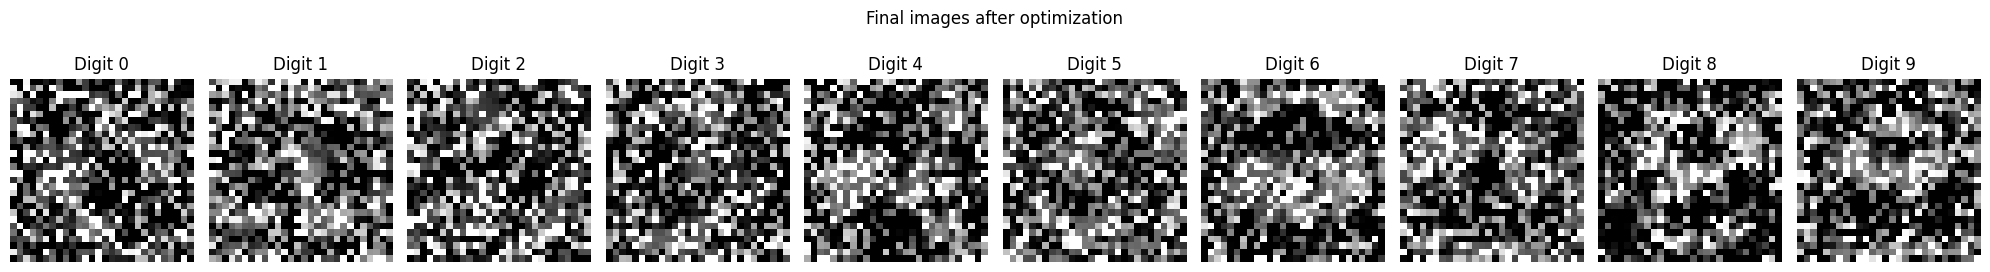

In [ ]:
final_images = inputs.detach().cpu()

fig,axes = pyplot.subplots(1,10, figsize = (20,3))
for i in range(10):
  axes[i].imshow(final_images[i][0], cmap = "grey")
  axes[i].axis("off")
  axes[i].set_title(f"Digit {i}")
pyplot.suptitle("Final images after optimization")
pyplot.tight_layout()
pyplot.show()

##**Animation**:

In [ ]:
from matplotlib import animation
from IPython.display import HTML

fig_anim,axes_anim = pyplot.subplots(1,10, figsize = (20,3))

def animate(frame):
  imgs = images[frame]

  for i, ax in enumerate(axes_anim):
    ax.clear()
    ax.imshow(imgs[i, 0], cmap = "grey")
    ax.axis("off")
    ax.set_title(f"Digit {i}")

anim = animation.FuncAnimation(fig_anim, animate, frames = len(images), interval = 100)
pyplot.close(fig_anim)

display(HTML(anim.to_html5_video()))

anim.save("dream.gif", writer = 'pillow')

##**Images over time**:

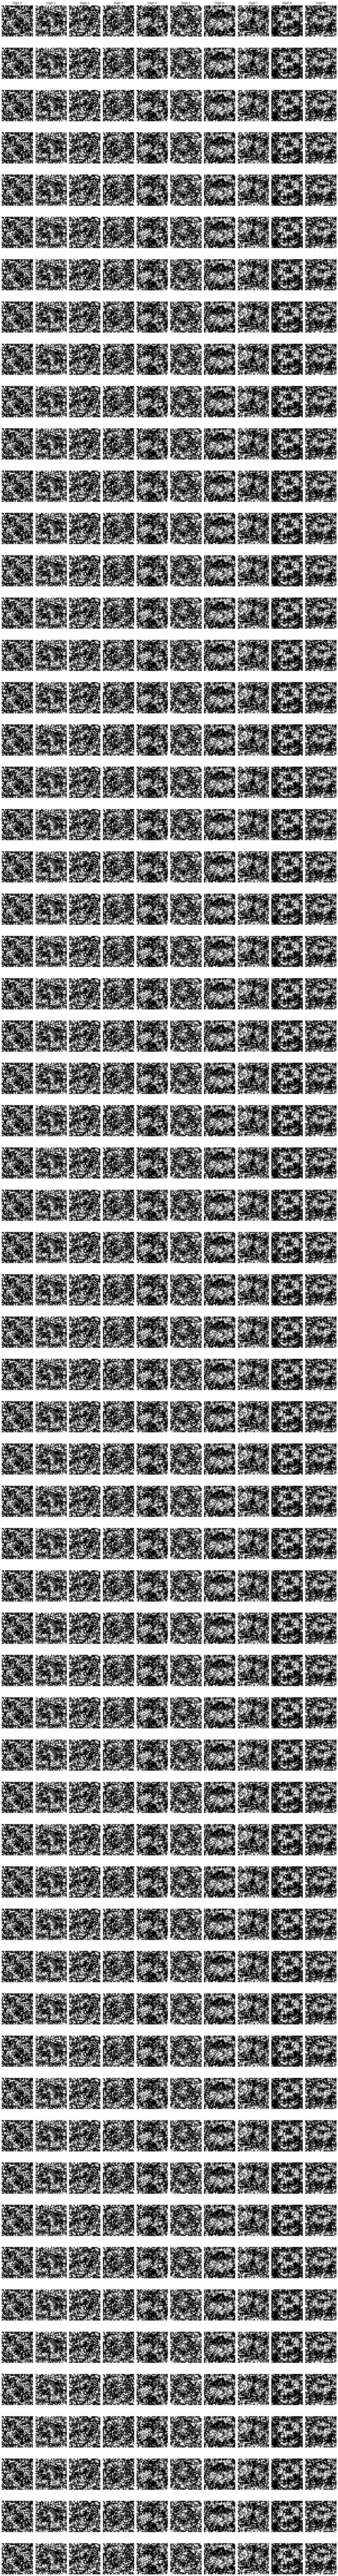

In [ ]:
import matplotlib.pyplot as plt

snapshots = images

fig, axes = plt.subplots(len(snapshots), 10, figsize = (20, 2.5 * len(snapshots)))

for row, img_batch in enumerate(snapshots):
  for col in range(10):
    ax = axes[row,col]
    img = img_batch[col, 0].numpy()
    ax.imshow(img, cmap = "gray")
    ax.axis("off")
    if row == 0:
      ax.set_title(f"Digit {col}")
  axes[row, 0].set_ylabel(f"Epoch {row * 5}")



plt.tight_layout()
plt.show()

##**Confidence**:

<ipython-input-16-57e9bed0790a>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  confidence = torch.tensor(target_prob_hist)


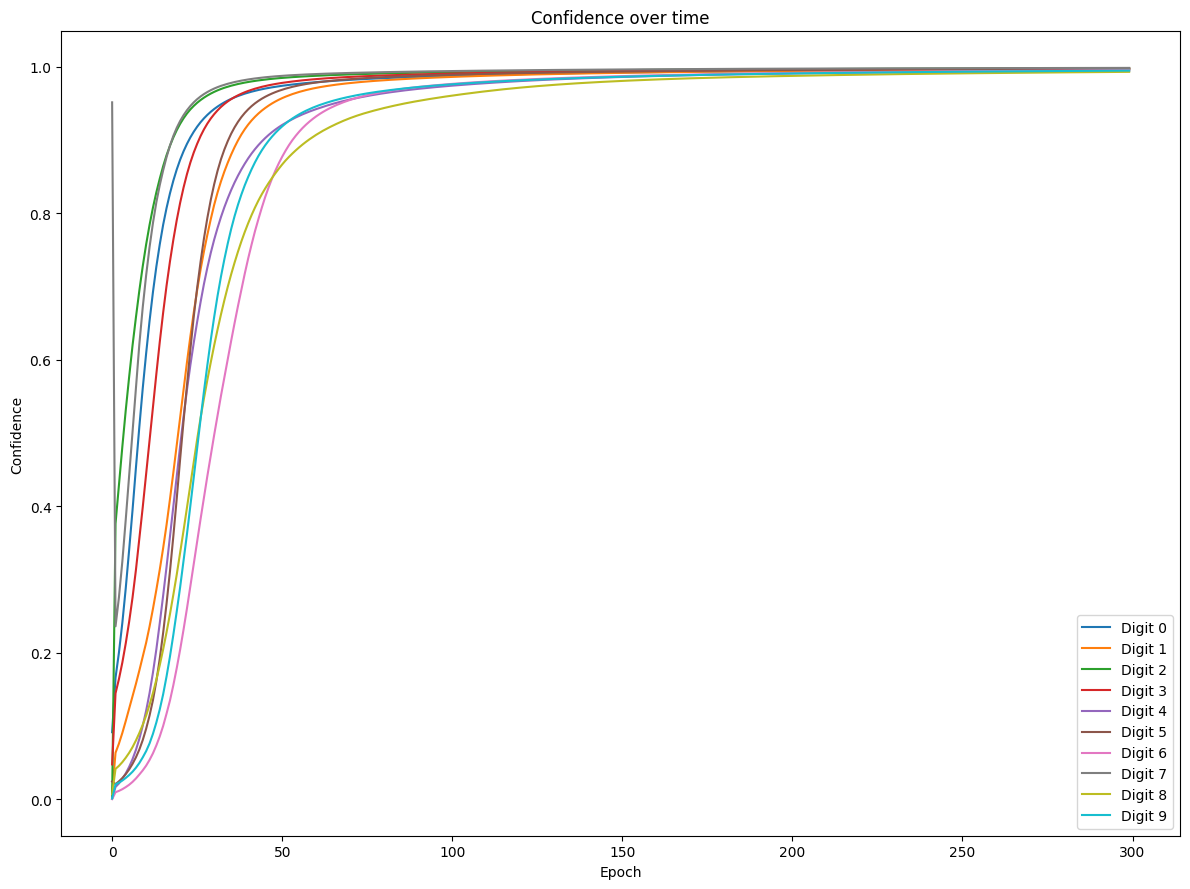

In [ ]:
confidence = torch.tensor(target_prob_hist)

plt.figure(figsize = (12,9))
for i in range(10):
  plt.plot(confidence[:, i], label = f"Digit {i}")
plt.xlabel("Epoch")
plt.ylabel("Confidence")
plt.title("Confidence over time")
plt.legend()
plt.tight_layout()
plt.show()

The significant increase in the model's confidence scores over time, as observed in the graph, indicated that the neural network has efficiently learned to associate each optimized input image with its correspoding target digit.

 Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?

No, the generated images do not resemble real MNIST digits.

The optimization process of our pretrained neural network is designed to maximize the model's confidence in its predictions rather than generating images that resemble hand-written digits to the human eye. The optimization modifies the pixel values in a way that increases the output score.

##**Task 2**:
------------------------------------------------------------------------

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

In [18]:
net.eval() #setting neural network to evaluation
#####we are trying to generate an image baring similiarity to two digits
targets = [1,5]

inputs = torch.nn.Parameter(torch.randn(1,1,28,28, device = device))
optimizer = torch.optim.Adam([inputs], 0.01)

probs_over_time = []

#optimization
for epoch in range(200):
  optimizer.zero_grad()
  output= net(inputs)
  probs = torch.nn.functional.softmax(output, dim =1)
  target_probs = probs[0,targets]

  probs_over_time.append(target_probs.detach().cpu().numpy())

  loss = -torch.mean(torch.log(target_probs))
  loss.backward()
  optimizer.step()

  with torch.no_grad():
    inputs.clamp_(0,1)


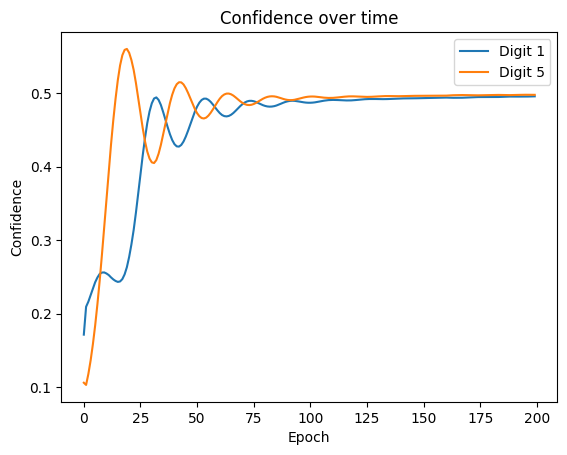

In [19]:
from matplotlib import pyplot as plt
probs_over_time = torch.tensor(probs_over_time)
plt.plot(probs_over_time[:,0], label = "Digit 1")
plt.plot(probs_over_time[:,1], label = "Digit 5")
plt.xlabel("Epoch")
plt.ylabel("Confidence")
plt.title("Confidence over time")
plt.legend()

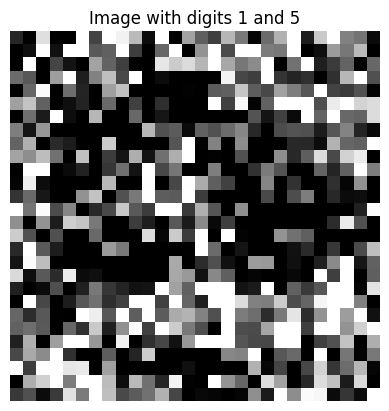

In [20]:
final = inputs.detach().cpu().squeeze().numpy()
plt.imshow(final, cmap = 'gray')
plt.title(f"Image with digits {targets[0]} and {targets[1]}")
plt.axis("off")
plt.show()

During training, we pass the image through the neural network and extract the softmax probabilites assigned to the two target classes. Then, we define a loss function that maximizes the model's confidence in both digits by taking the mean of the log-probabilites of the two target classes. This resulted in the network simultaneously recognizing features associated with both digit classes.


##**Task 3**:
-------------------------------------------------------------------
3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

##**Optimization**:

In [26]:
net.eval()
lambdas = [0.001, 0.01, 0.1, 1, 10]
images = []
confidences = []

for lambda_l2 in lambdas:
  inputs = torch.nn.Parameter(torch.randn(10, 1, 28, 28, device = device))
  targets = torch.arange(10, device = device).long()
  optimizer = torch.optim.Adam([inputs],lr = 0.01)

  for epoch in range(200):
    optimizer.zero_grad()
    outputs = net(inputs)

    cross_ent = torch.nn.functional.cross_entropy(outputs, targets)
    l2_penalty = lambda_l2 * inputs.pow(2).mean()
    loss = cross_ent + l2_penalty

    loss.backward()
    optimizer.step()

    with torch.no_grad():
      inputs.clamp_(0,1)

  images.append(inputs.detach().cpu().clone())
  with torch.no_grad():
    probs = torch.nn.functional.softmax(net(inputs), dim = 1)
    confidences.append(probs[range(10), targets].detach().cpu().numpy())



##**Final images for different lambda values**:

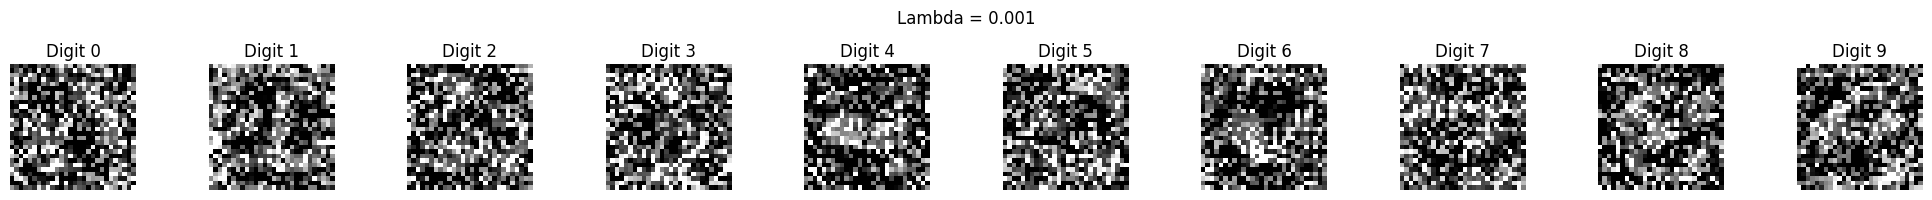

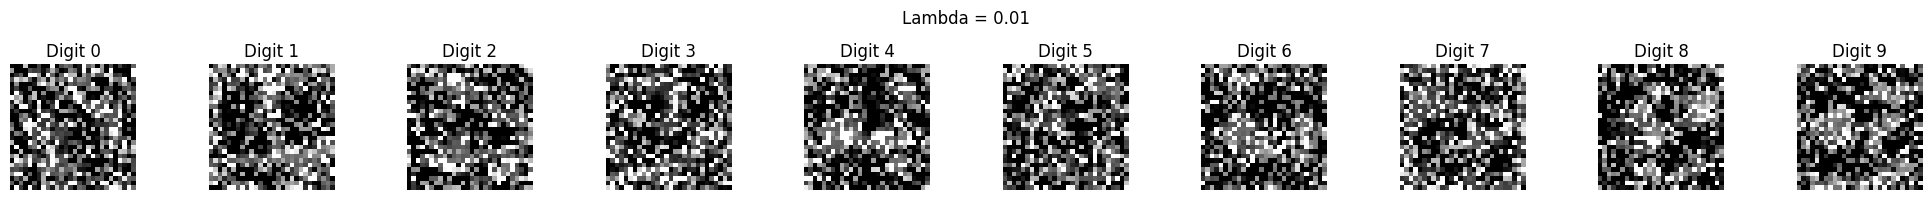

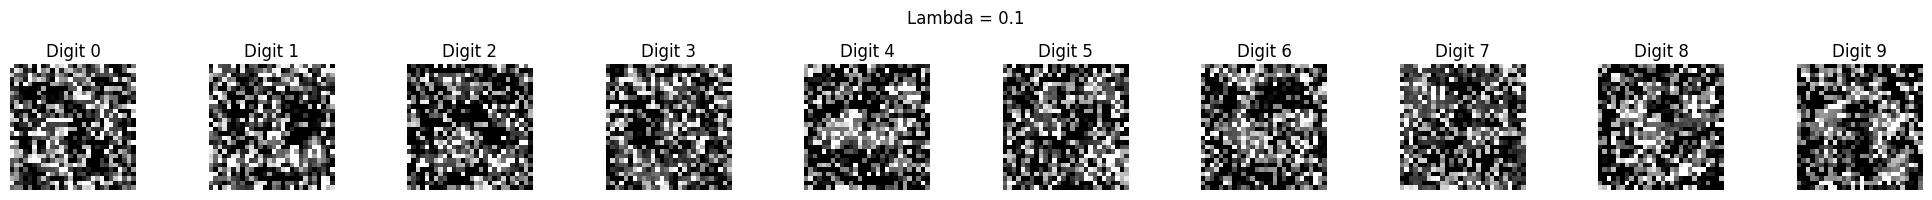

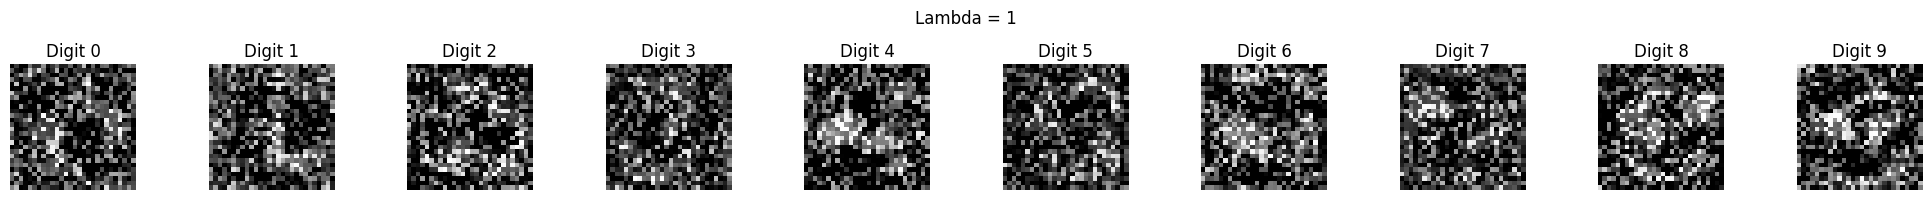

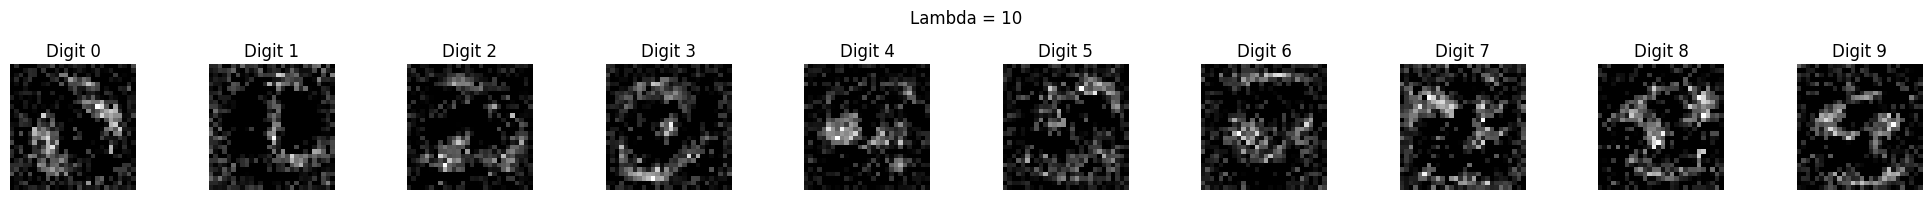

In [27]:
for idx, (img_batch, lam) in enumerate(zip(images, lambdas)):
  fig, axes = plt.subplots(1,10, figsize = (20, 2))
  for i in range(10):
    axes[i].imshow(img_batch[i,0], cmap = 'gray')
    axes[i].axis('off')
    axes[i].set_title(f"Digit {i}")
  plt.suptitle(f"Lambda = {lam}")
  plt.tight_layout()
  plt.show()

##**Animation**:

In [33]:
from matplotlib import animation
from IPython.display import HTML


net.eval()
lambda_l2 = 10 # we will make an animation for lambda = 10
inputs = torch.nn.Parameter(torch.randn(10, 1, 28, 28, device = device))
targets = torch.arange(10, device = device).long()
optimizer = torch.optim.Adam([inputs],lr = 0.01)

images = []
confidences = []

for epoch in range(200):
    optimizer.zero_grad()
    outputs = net(inputs)

    cross_ent = torch.nn.functional.cross_entropy(outputs, targets)
    l2_penalty = lambda_l2 * inputs.pow(2).mean()
    loss = cross_ent + l2_penalty

    loss.backward()
    optimizer.step()

    with torch.no_grad():
      inputs.clamp_(0,1)


    if epoch % 5 -- 0 or epoch == 199:
      images.append(inputs.detach().cpu().clone())
      probs = torch.nn.functional.softmax(net(inputs), dim = 1)
      confidences.append(probs[range(10), targets].detach().cpu().numpy())



In [30]:
fig_anim, axes_anim = plt.subplots(1,10, figsize = (20,3))

def animate(frame):
  imgs = images[frame]

  for i, ax in enumerate(axes_anim):
    ax.clear()
    ax.imshow(imgs[i, 0], cmap = "gray")
    ax.axis("off")
    ax.set_title(f"Digit {i}")


anim = animation.FuncAnimation(fig_anim, animate, frames = len(images), interval = 100)
plt.close(fig_anim)

display(HTML(anim.to_html5_video()))

##**Confidence**:

Text(0.5, 1.0, 'Confidence over time')

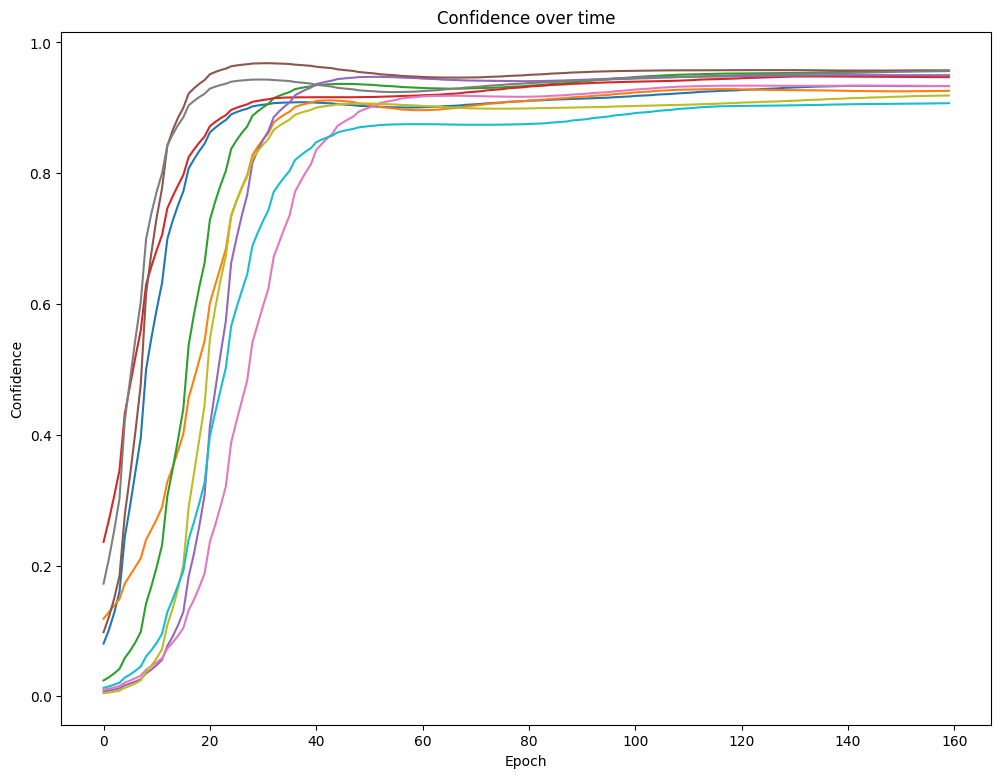

In [34]:
import numpy as np
confidences = np.array(confidences)

plt.figure(figsize = (12,9))
for i in range(10):
  plt.plot(confidences[:, i], label = f"Digit {i}")
plt.xlabel("Epoch")
plt.ylabel("Confidence")
plt.title("Confidence over time")


Yes, some of the generated images do resemble real MNIST digits. After adding a L2 penalty we suppressed some noise and encouraged the model to generated smoother looking digit images. Our neural network classified the images with high confidence for all values $ \lambda \in [0.001, 10]$. For low $\lambda$ values, the generated images are quite noisy but still confidently recognized. As the $\lambda$ values increased, the results became clearer and easier to interpret visually. For large $\lambda$ values ($\lambda = 10$), the regularization became too strong leading to blurry images that lacked key digit-defining features.

